# Rock Paper Scissors Image Classification 

## Executive Summary

### Project goal

This notebook documents the development of an end-to-end computer vision pipeline that classifies smartphone images of hand gestures into rock, paper, and scissors, covering data organization, preprocessing, model training, and evaluation. The project emphasizes reproducibility and real-world variability (lighting, backgrounds, and camera differences) to produce a model that generalizes beyond curated examples.

### Objectives
- Create a clean, reproducible dataset split for supervised learning (train/validation/test).
- Implement a reliable image input pipeline in TensorFlow/Keras (loading, resizing, normalization).
- Establish a baseline model (feed-forward neural network) as a performance reference point.
- Iterate toward stronger generalization using regularization, optimization improvements, augmentation, and CNN/transfer learning techniques.

### Dataset & structure
- Images are collected using phones, so they naturally vary in resolution, lighting, background, and framing.
- Directory structure (one folder per class, per split):  
  - `data/rps/train/{rock,paper,scissor}`  
  - `data/rps/val/{rock,paper,scissor}`  
  - `data/rps/test/{rock,paper,scissor}` 
- Each image is expected to contain a single dominant gesture matching the folder label.

### Approach (high level)
- **Data ingestion**: Load labeled images from the directory structure into batched datasets.
- **Preprocessing**: Standardize input size and scale pixel values for stable training.
- **Modeling**: Train a baseline FFNN, then progressively introduce more suitable vision methods (CNNs, transfer learning).
- **Evaluation**: Track training/validation curves, report test performance once, and analyze misclassifications to guide iteration.

### Success criteria
- Reproducible training runs with a fixed validation split and a truly held-out test set.
- Clear baseline performance and measurable improvements from each subsequent technique.
- Error patterns are interpretable and lead to actionable data/model refinements.


## Setup

This notebook uses TensorFlow/Keras to build an image classification workflow, including directory-based data loading via `tf.keras.utils.image_dataset_from_directory`. 
A fixed random seed is used to improve reproducibility across runs (dataset shuffling, initialization, and training behavior).

In [3]:
# Core
import os
from pathlib import Path
import random

# Numeric & plotting (optional but useful)
import numpy as np
import matplotlib.pyplot as plt

# Image handling 
import PIL

# ML
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# --- Reproducibility ---
SEED = 123
random.seed(SEED)
np.random.seed(SEED)
tf.keras.utils.set_random_seed(SEED)

# --- Paths ---
DATA_DIR = Path("data/rps")
TRAIN_DIR = DATA_DIR / "train"
VAL_DIR   = DATA_DIR / "val"
TEST_DIR  = DATA_DIR / "test"

# --- Image / training constants ---
IMG_H, IMG_W = 224, 224
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

# --- Environment checks ---
print("TensorFlow:", tf.__version__)

# --- Quick directory sanity checks ---
assert TRAIN_DIR.exists(), f"Missing: {TRAIN_DIR}"
assert VAL_DIR.exists(), f"Missing: {VAL_DIR}"
assert TEST_DIR.exists(), f"Missing: {TEST_DIR}"

print("Train classes:", sorted([p.name for p in TRAIN_DIR.iterdir() if p.is_dir()]))
print("Val classes:  ", sorted([p.name for p in VAL_DIR.iterdir() if p.is_dir()]))
print("Test classes: ", sorted([p.name for p in TEST_DIR.iterdir() if p.is_dir()]))


TensorFlow: 2.17.0
Train classes: ['paper', 'rock', 'scissor']
Val classes:   ['.ipynb_checkpoints', 'paper', 'rock', 'scissor']
Test classes:  ['.ipynb_checkpoints', 'paper', 'rock', 'scissor']


## Load & Inspect Data

### Load Training Data

This phase loads the training split from the folder structure into a batched `tf.data.Dataset` using `tf.keras.utils.image_dataset_from_directory`.  
The loader returns `(images, labels)` batches where `images` has shape `(batch_size, image_height, image_width, channels)` and `labels` contains the class indices. 
Finally, a small grid of samples is visualized to validate that labels match the images and that resizing works as expected. 


In [5]:
# Load the training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    labels="inferred",
    label_mode="int",
    image_size=(IMG_H, IMG_W),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
)

# Class names (folder names in alphabetical order by default)
class_names = train_ds.class_names
print("Classes:", class_names)

# Dataset spec (useful to verify shapes/dtypes)
print("Element spec:", train_ds.element_spec)

# Grab one batch and print shapes
image_batch, label_batch = next(iter(train_ds))
print("Image batch shape:", image_batch.shape)  # (batch, H, W, C)
print("Label batch shape:", label_batch.shape)  # (batch,)


Found 6 files belonging to 3 classes.
Classes: ['paper', 'rock', 'scissor']
Element spec: (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
Image batch shape: (6, 224, 224, 3)
Label batch shape: (6,)


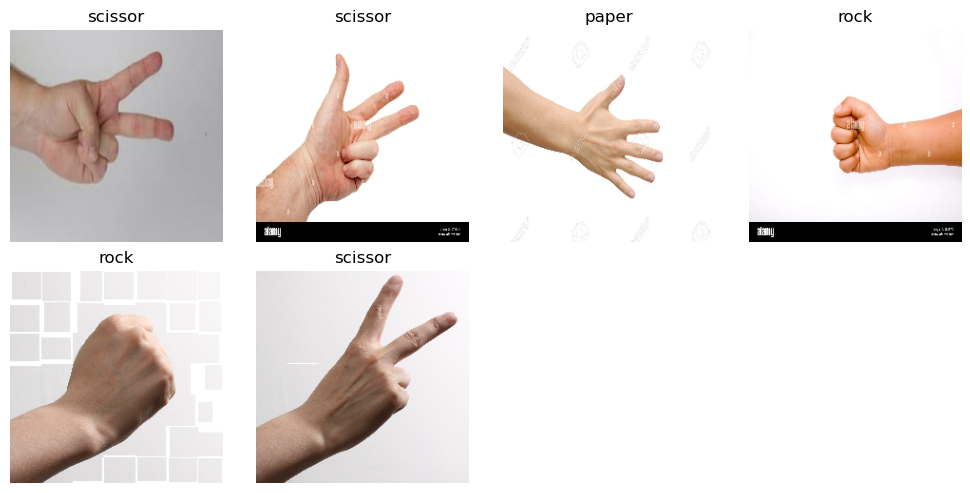

In [6]:
plt.figure(figsize=(10, 5))

images, labels = next(iter(train_ds))
n = min(8, images.shape[0])  

for i in range(n):
    ax = plt.subplot(2, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[int(labels[i])])
    plt.axis("off")

plt.tight_layout()
plt.show()


### Load validation data

Load the validation split from `data/rps/val` using the same preprocessing settings (image size, label encoding, batch size) as the training dataset to ensure a consistent input format. 
Shuffling is typically disabled for validation so evaluation is deterministic (the same samples appear in the same order each epoch). 
After loading, we print the class names and inspect one batch to confirm the tensor shapes match the training pipeline.


In [8]:
# Load the validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    labels="inferred",
    label_mode="int",
    image_size=(IMG_H, IMG_W),
    batch_size=BATCH_SIZE,
    shuffle=False,
)

print("Validation classes:", val_ds.class_names)
print("Validation element spec:", val_ds.element_spec)

# Check one batch shape
val_images, val_labels = next(iter(val_ds))
print("Val image batch shape:", val_images.shape)
print("Val label batch shape:", val_labels.shape)


Found 4 files belonging to 3 classes.
Validation classes: ['paper', 'rock', 'scissor']
Validation element spec: (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
Val image batch shape: (4, 224, 224, 3)
Val label batch shape: (4,)


## Normalization (pixel scaling)

Smartphone images are loaded as `uint8` tensors with pixel values in the `[0, 255]` range, so scaling inputs to `[0, 1]` is a standard first step for stable neural network training. 
Normalization can be applied in two equivalent, professional ways: (1) map a `Rescaling(1./255)` layer over the dataset, or (2) include the same `Rescaling` layer as the first layer of the model so preprocessing is bundled with the model artifact. 
For portfolio projects, placing `Rescaling` inside the model is often preferred because it keeps training and inference preprocessing consistent by design.


In [10]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

## Build the baseline model (FFNN)

This baseline model is intentionally simple: it treats each image as a vector of pixel intensities and learns a direct mapping to one of the three gesture classes. This creates a clear reference point before introducing architectures that exploit spatial structure (CNNs). 
The first layer is `Rescaling(1./255)`, which converts raw pixel values from `[0, 255]` into `[0, 1]`; keeping this step inside the model helps ensure the exact same preprocessing is applied during both training and later inference. 

### Architecture (what each layer does)
- **Rescaling**: Standardizes input scale for more stable optimization. 
- **Flatten**: Converts the image tensor of shape `(H, W, 3)` into a single 1D feature vector, removing spatial relationships between pixels (this is why it’s a baseline, not the final approach).  
- **Dense (ReLU)**: Learns non-linear feature combinations from the flattened pixel vector.  
- **Dense (Softmax)**: Outputs a probability distribution over the 3 classes.

### Compilation choices (optimizer, loss, metrics)
- **Optimizer — Adam**: Adam is a widely used adaptive gradient method; its default learning rate is `0.001`, and it includes momentum-like terms (`beta_1=0.9`, `beta_2=0.999`) that often work well as a strong starting point for image models. 
- **Loss — SparseCategoricalCrossentropy**: This loss is appropriate when there are 2+ classes and labels are provided as integer class IDs (e.g., 0/1/2), rather than one-hot vectors.   
- **Metric — SparseCategoricalAccuracy**: Reports classification accuracy using the same integer-label convention. (This makes training logs easy to interpret alongside loss.)

Note: Because the final layer uses `softmax`, the loss is used with `from_logits=False` (the default). 


In [12]:
num_classes = len(class_names)

# Baseline: Feed-Forward Neural Network (FFNN)
baseline_ffnn = keras.Sequential(
    [
        layers.Rescaling(1./255, input_shape=(IMG_H, IMG_W, 3)),
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dense(num_classes, activation="softmax"),
    ],
    name="baseline_ffnn",
)

baseline_ffnn.summary()

baseline_ffnn.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="accuracy")],
)


C:\Users\evisp\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "baseline_ffnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 150528)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      19,267,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,268,099 (73.50 MB)

 Trainable params: 19,268,099 (73.50 MB)

 Non-trainable params: 0 (0.00 B)

## Train the model

This phase runs supervised training using `model.fit()` with the training dataset and evaluates progress each epoch on the validation dataset.   
Training is configured with a fixed number of epochs, but practical training control is handled via callbacks:
- **EarlyStopping** monitors a validation metric (commonly `val_loss`) and stops training when it stops improving for a set number of epochs (“patience”), reducing overfitting and wasted compute. 
- **ModelCheckpoint** saves the best model during training (e.g., the epoch with the lowest `val_loss`), so the best-performing weights are preserved even if later epochs degrade validation performance. 

The output of `model.fit()` is a `History` object containing per-epoch metrics (loss/accuracy and validation loss/accuracy), which will be used in the next phase for learning-curve visualization and diagnostics. 


In [14]:
from pathlib import Path

# Training configuration
EPOCHS = 30

# Where to save the best model
MODELS_DIR = Path("models")
MODELS_DIR.mkdir(parents=True, exist_ok=True)
best_model_path = MODELS_DIR / "baseline_ffnn_best.keras"

# Callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=str(best_model_path),
        monitor="val_loss",
        save_best_only=True,
        mode="min",
        verbose=1,
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        mode="min",
        restore_best_weights=True,
        verbose=1,
    ),
]

# Train
history = baseline_ffnn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
)

print(f"Best model saved to: {best_model_path}")


Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1667 - loss: 1.9069
Epoch 1: val_loss improved from inf to 58.77528, saving model to models\baseline_ffnn_best.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.1667 - loss: 1.9069 - val_accuracy: 0.5000 - val_loss: 58.7753
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.6667 - loss: 80.3217
Epoch 2: val_loss did not improve from 58.77528
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.6667 - loss: 80.3217 - val_accuracy: 0.2500 - val_loss: 175.0636
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.3333 - loss: 243.9753
Epoch 3: val_loss did not improve from 58.77528
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.3333 - loss: 243.9753 - val_accuracy: 0.2500 - val_loss: 144.2225
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.3333 - loss: 199.7624
Epoch 4: val_loss did not improve from 58.77528
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.3333 - loss: 199.7

## Visualize learning curves (accuracy & loss)

Training logs stored in the `History` object make it possible to track how the model is learning over time by plotting training vs. validation **accuracy** and **loss** across epochs. 
These curves are a primary diagnostic tool: widening gaps between training and validation metrics often indicate overfitting, while both curves staying low can indicate underfitting or optimization issues.  
The plots below follow the common TensorFlow approach of using two side-by-side subplots: accuracy on the left, loss on the right. 


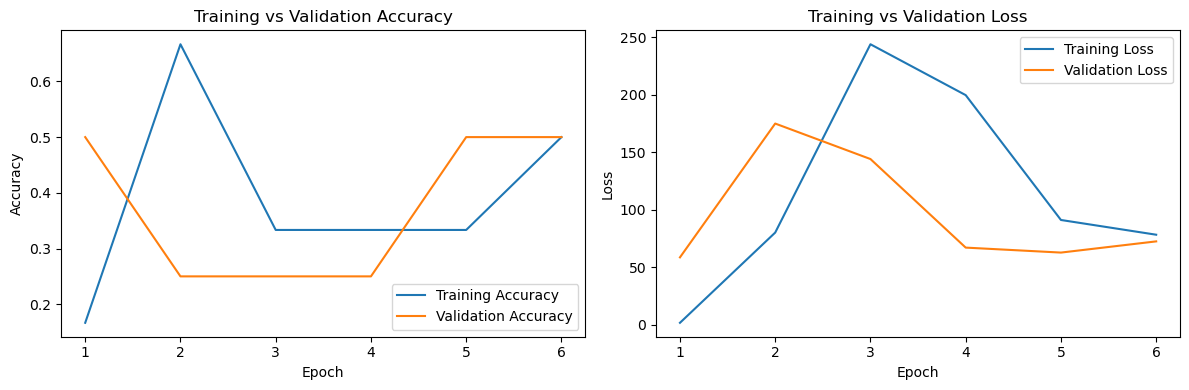

In [16]:
# Extract metrics from the History object
acc = history.history.get("accuracy", [])
val_acc = history.history.get("val_accuracy", [])
loss = history.history.get("loss", [])
val_loss = history.history.get("val_loss", [])

epochs_range = range(1, len(acc) + 1)

# Plot with subplots (1 row, 2 columns)
plt.figure(figsize=(12, 4))

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")

# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")

plt.tight_layout()
plt.show()


## Model performance (test set) & confusion matrix

This phase evaluates the trained model on the held-out **test** split and reports performance metrics that go beyond a single accuracy number.  
First, `model.evaluate()` is used to compute the overall test loss and accuracy using the same metrics defined at compile time.  
Next, predictions are generated for the full test dataset and summarized with a **confusion matrix**, which counts how often each true class is predicted as each other class.   
The confusion matrix is especially useful for diagnosing systematic mistakes (e.g., confusing rock vs. scissors under certain lighting/background conditions). 

In [18]:
# Build / load the test dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    labels="inferred",
    label_mode="int",
    image_size=(IMG_H, IMG_W),
    batch_size=BATCH_SIZE,
    shuffle=False,
)

print("Test classes:", test_ds.class_names)
print("Test element spec:", test_ds.element_spec)

# Quick batch shape check
test_images, test_labels = next(iter(test_ds))
print("Test image batch shape:", test_images.shape)
print("Test label batch shape:", test_labels.shape)


Found 4 files belonging to 3 classes.
Test classes: ['paper', 'rock', 'scissor']
Test element spec: (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
Test image batch shape: (4, 224, 224, 3)
Test label batch shape: (4,)


In [19]:
# --- 1) Evaluate on the test set (aggregate metrics) ---
test_loss, test_acc = baseline_ffnn.evaluate(test_ds, verbose=0)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc:.4f}")

Test loss: 112.8102
Test accuracy: 0.7500


In [20]:
# --- 2) Collect predictions and true labels from the test dataset ---
y_true = tf.concat([y for _, y in test_ds], axis=0)

y_prob = baseline_ffnn.predict(test_ds, verbose=0)
y_pred = tf.argmax(y_prob, axis=1)

print("y_true shape:", y_true.shape)
print("y_pred shape:", y_pred.shape)


y_true shape: (4,)
y_pred shape: (4,)


In [21]:
# --- 3) Compute confusion matrix ---
cm = tf.math.confusion_matrix(
    labels=y_true,
    predictions=y_pred,
    num_classes=len(class_names),
).numpy()


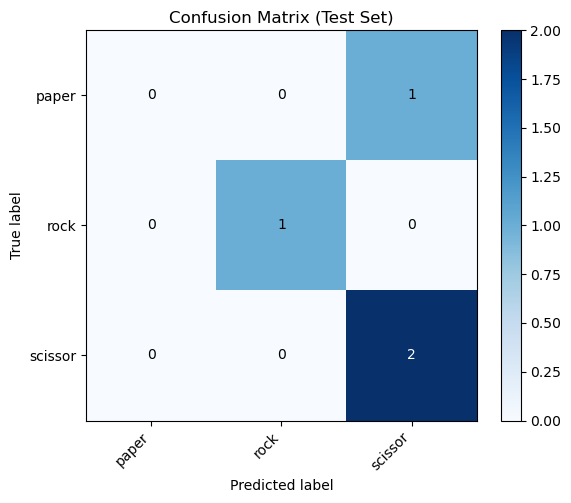

In [22]:
# --- 4) Plot confusion matrix (raw counts) ---
plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Test Set)")
plt.colorbar()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45, ha="right")
plt.yticks(tick_marks, class_names)

# Annotate counts
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(
            j, i, format(cm[i, j], "d"),
            ha="center", va="center",
            color="white" if cm[i, j] > thresh else "black"
        )

plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()
